# Predict

Use this notebook to train/test models. Using the node system will automatically allow you to cache the trained model for use in the server. Currently the only working model node is named `train_honest_forward`.

In [22]:
subset = dict( 

    random_state = 88, 
    shuffle = True, 
    test_size = 0.1, 
    train_size = 0.9
)

### Train

In [23]:
import nodes
import verbose
verbose.set_level( 0 )

model = nodes.find( "train_honest_forward" ).get_result( 
    
    subset = { ** subset, "type": "train_split" }, 
    n_estimators = 100, 
    max_depth = 20,
    max_features = 1.0,
    n_jobs = 7
)

assembling patches: 100%|████████████████████████████████████████████████████████████████████████████████████████| 61279/61279 [00:11<00:00, 5174.56it/s]
training...
{'n_estimators': 100, 'max_depth': 20, 'max_features': 1.0, 'n_jobs': 7}
training estimators: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [12:22<00:00, 49.48s/it]
done


### Validate

In [25]:
import require
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tqdm import tqdm
import sys

n_outcomes = len( require.single( "owid_outcomes" ))
subset_indexing = require.single( "subset_indexing" )

scaler = MinMaxScaler( )
scaler.fit( nodes.find( "data_for_country" ).get_result( "Germany" )) # normalize against reference df 

def score( df_true, df_pred ):

    # custom variance weighting
    df_pred = pd.DataFrame( scaler.transform( df_pred ), columns = df_pred.columns )
    df_true = pd.DataFrame( scaler.transform( df_true ), columns = df_true.columns )
    return r2_score( df_true.iloc[ :, :n_outcomes ], df_pred.iloc[ :, :n_outcomes ])

def validate( model, evalset ):
    
    sum = 0
    with tqdm( file = sys.stdout, total = len( evalset ), desc = "evaluation" ) as bar:
    
        for i, point in enumerate( evalset ):
    
            df = point.df
            df_pred = model.predict_replace( df, start = 0, callback = lambda p: bar.update( i + p - bar.n ))
        
            assert not df.isna( ).any( ).any( )
            assert not df_pred.isna( ).any( ).any( )
    
            s = score( df, df_pred )
            bar.clear( )
            print( f"r2 in { point.country }: { s :.2f}" )
            sum += s
    
    avg = sum / len( evalset )
    print( f"\naverage r2 score: { avg :.2f}\n" )


trainset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "train_split" })
testset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "test_split" })

print( "test set validation" )
validate( model, testset )


test set validation
r2 in Ireland: 0.01                                                                                                                                      
r2 in Guyana: -0.32                                                                                                                                      
r2 in Denmark: -0.57                                                                                                                                     
r2 in Tunisia: 0.08                                                                                                                                      
r2 in Cyprus: -0.68                                                                                                                                      
r2 in Suriname: 0.14                                                                                                                                     
r2 in Turkey: -1.54                                     

In [26]:
validate( model, trainset )

r2 in Argentina: 0.69                                                                                                                                    
r2 in United States Virgin Islands: 0.35                                                                                                                 
r2 in Spain: 0.86                                                                                                                                        
r2 in Israel: 0.07                                                                                                                                       
r2 in Palestine: -0.63                                                                                                                                   
r2 in Moldova: 0.77                                                                                                                                      
r2 in Hungary: 0.66                                                         

### Plot

new_deaths_smoothed_per_million in Croatia
inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [00:15<00:00, 15.66s/it]


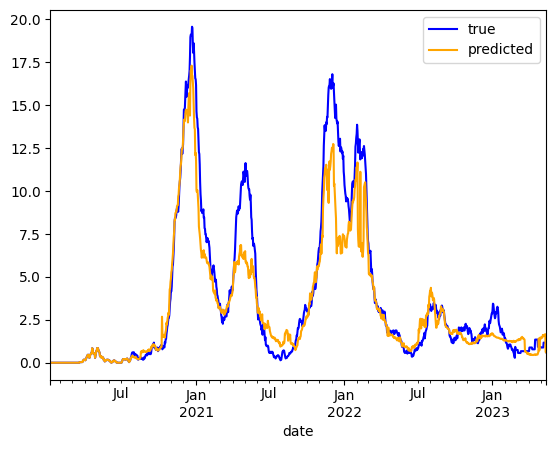

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import require
import nodes
import verbose
verbose.set_level( 0 )

data_for_country = require.single( "data_for_country" )
subset_indexing = require.single( "subset_indexing" )
crop_to_valid_range = require.single( "crop_to_valid_range" )

trainset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "train_split" })
testset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "test_split" })
point = trainset[ 13 ]
country = point.country
#country = "Switzerland"
df = crop_to_valid_range( data_for_country.get_result( country ))

time_range = slice( 0, None )
column_name = "new_deaths_smoothed_per_million"
column = df.columns.tolist( ).index( column_name )
start = 200

print( f"{ df_pred.columns[ column ]} in { country }" )

with tqdm( file = sys.stdout, total = 1.0, desc = "inference" ) as bar:

    df_pred = model.predict_replace( df, start = start, callback = lambda p: bar.update( p - bar.n ))

assert not df.isna( ).any( ).any( )
assert not df_pred.isna( ).any( ).any( )


df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )


line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )


